In this notebook, you'll see how to create a linear regression model using the `scikit-learn` library.

We'll be using a cleaned up version of the auto mpg dataset, with the goal being to predict a car's mpg based on the other attributes of that car.

In [38]:
import pandas as pd

In [39]:
cars = pd.read_csv('../data/auto_mpg_cleaned.csv')

In [40]:
cars.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
0,18.0,8,307.0,130,3504,12.0,70,American,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,American,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,American,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,American,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,American,ford torino


First, let's do some exploration to see how the variables are related to mpg.

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact
%matplotlib inline

Let's first look at the numeric predictors.

In [42]:
@interact(x = ['displacement', 'horsepower', 'weight', 'acceleration'])
def make_scatter(x):
    cars.plot(kind = 'scatter', x = x, y = 'mpg');

interactive(children=(Dropdown(description='x', options=('displacement', 'horsepower', 'weight', 'acceleration…

There are also some discrete numeric variables, and some categorical variables.

In [43]:
@interact(x = ['cylinders', 'origin'])
def make_box(x):
   sns.boxplot(data = cars, x = x, y = 'mpg')

interactive(children=(Dropdown(description='x', options=('cylinders', 'origin'), value='cylinders'), Output())…

Before proceeding, we are going to transform the categorical and discrete predictors. We will do this by creating new indicator columns for all of the different possible levels of these variables. We can accomplish this by using the `get_dummies` function from `pandas`.

In [44]:
cars['cylinders'] = cars['cylinders'].astype('category')

cars = cars.drop(columns = ['car_name', 'model_year'])    

cars = pd.get_dummies(cars, drop_first=True)

In [45]:
cars.head()

,mpg,displacement,horsepower,weight,acceleration,cylinders_4,cylinders_5,cylinders_6,cylinders_8,origin_European,origin_Japanese
0,18.0,307.0,130,3504,12.0,0,0,0,1,0,0
1,15.0,350.0,165,3693,11.5,0,0,0,1,0,0
2,18.0,318.0,150,3436,11.0,0,0,0,1,0,0
3,16.0,304.0,150,3433,12.0,0,0,0,1,0,0
4,17.0,302.0,140,3449,10.5,0,0,0,1,0,0


The get_dummies method created 4 columns out of the original cylinders column and two columns out of the original origin column. In these columns, the corresponding value is marked with a 1, and all other values are maked with a 0. You may notice that there were 5 possible values for the number of cylinders and 3 possible values for the origin in the original dataset. The reason for this is that, for example, we know that if a car is not European or Japanese, then it must be American (at least in the dataset we are working with).

Now, let's split off out predictors and response variables.

In [47]:
# Predictors:
X = cars.drop(columns = 'mpg')

# Response:
y = cars['mpg']

When building models, we are often interested on the predictive power of the model. We are not interested in how well the model predicts on data that it has already seen, but instead on how well it generalizes to new, unseen data.

To evaluate this, we will set aside a portion of the full dataset as our _test set_. The remaining portion, which will be called the _training set_, will be used to fit the model. .

In [50]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 321)

In [52]:
from sklearn.linear_model import LinearRegression

In [53]:
lr = LinearRegression()

In [55]:
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [63]:
from sklearn.metrics import r2_score, mean_absolute_error

Now, let's look at the $R^2$ score. Recall that this shows how much of the variation in the mpg values which can be accounted for by using our model. First, let's look at the training set.

In [68]:
r2_score(y_train, lr.predict(X_train))

0.7669338134439346

If we are wanting to use our model to make predictions on new data, then we don't really care how it does on the training data. Instead, we want to see how well it generalizes to new data.

In [70]:
y_pred = lr.predict(X_test)

r2_score(y_test, y_pred)

0.6924754329607551

Typically, there will be a drop in perfomance from the training set to the test set.

We can also look at other metrics. For example, the mean absolute error measures how far off the predictions are (in magnitude) on average. One bonus of using the mean absolute error is that it is measured in the same units as the response variable.

In [71]:
mean_absolute_error(y_train, lr.predict(X_train))

2.850135025561446

This shows that on average, the model's predictions are off, on average, by 2.85 miles per gallon. 

In [66]:
mean_absolute_error(y_test, y_pred)

3.1885550952582484

Again, there is a slight drop in performance from the training set to the test set.

What if we want to understand _how_ the model is making predictions? Since we are using a linear model, we can do this by looking at coefficients.

In [72]:
coefficients = pd.DataFrame({'variable': ['intercept'] + list(X.columns),
                             'coefficient': [lr.intercept_] + list(lr.coef_)})

In [73]:
coefficients

,variable,coefficient
0,intercept,35.420374
1,displacement,0.010964
2,horsepower,-0.093286
3,weight,-0.003651
4,acceleration,-0.029704
5,cylinders_4,7.699675
6,cylinders_5,11.799498
7,cylinders_6,3.426664
8,cylinders_8,5.805907
9,origin_European,1.154033


For the continuous variables, the coefficient represents the change in mpg that would occur for a one-unit change in the corresponding predictor, _all other predictors held constant_.

For example, our coefficients show that for every one unit increase in horsepower, all other variables held constant, there is a drop in mpg of 0.093286.

There is one strange value that stands out. It seems that according to the model, increasing displacement will increase mpg. However, if you look at the scatterplot above, it seems that there is a negative association between the two variables. Cars with higher than average displacement tend to have lower than average mpg.

This can happen for a number of reasons, but the cause for an unexpected coefficient sign is due to correlations with other predictor variables.

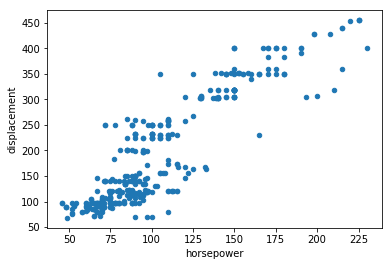

In [82]:
cars.plot(kind = 'scatter', x = 'horsepower', y = 'displacement');

We can see, for example, that displacement is strongly correlated with horsepower. One possible explanation for the positive coefficient on horsepower is that the effect of displacement has already been captured by the horsepower.

All of this to say that when you have correlated predictors, you need to exercise caution when interpreting them. It is always a good idea to do thorough exploratory analysis.

What about our categorical predictors? Let's look specifically at the origin variable. Since we dropped the origin_American variable when dummyizing, we can interpret the other two as the change in mpg from changing a car's origin to either European or Japanese, keeping all other variables fixed.

Our model is telling us that, all other variables held fixed, a European car will tend to get about 1.15 mpg higher than an American car, and a Japanese car will tend to get about 2.74 mpg higher than an American car.